# Projeto de Sinais

## Sinais e Sistemas Dinâmicos - Prof. Derzu Omaia

## Jansepetrus Brasileiro Pereira e Nathália de Vasconcelos Silva

Descrição do projeto: https://www.dropbox.com/s/wzibx7g7136um4z/Projeto.pdf?dl=0

### Importar todas as bibliotecas necessárias para o projeto

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy.signal import butter, lfilter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

### Definicao das funções de usuário a serem utilizadas

def plot_wav(wav, sample_rate, save_plot=False, nome_plot="", sufixo_nome=""):
    if(nome_plot == ""):
        from datetime import datetime
        nome_plot = str(datetime.now()).replace(":","-")
        
    times = np.arange(len(wav))/float(sample_rate)

    plt.figure(figsize=(30, 4))

    if(wav.ndim == 2):
        plt.fill_between(times, wav[:,0], wav[:,1], color='k') # para dual-channel
    else:
        plt.fill_between(times, wav)

    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    
    if(save_plot):
        plt.savefig(nome_plot + "_" + sufixo_nome + '.png', dpi=210)
    plt.show()

def plot_wav_freqDomain(fft_wav, freq, N, save_plot=False, nome_plot="", sufixo_nome=""):
    if(nome_plot == ""):
        from datetime import datetime
        nome_plot = str(datetime.now()).replace(":","-")
        
    plt.plot(freq, 1.0/N * np.abs(fft_wav))
    plt.grid()
    if(save_plot):
        plt.savefig(nome_plot + "_" + sufixo_nome + '.png', dpi=210)
    plt.show()

### Definição dos Parâmetros de Execução

In [2]:
####
# Parametros de Execucao
####
PLOT_SINAL_ORIGINAL = False
PLOT_SINAL_FFT = False
PLOT_SINAL_FFT_SHIFT = False
PLOT_SINAL_FFT_SHIFT_BUTTER = False
MONO = True
MONO_ESQ = True
STEREO = not MONO
MONO_DIR = not MONO_ESQ

### Percorrer a pasta do dataset IRMAS, abrir todos os arquivos .wav e aplicar a transformada de Fourier

ROOT_PATH = 'IRMAS-TrainingData_red' + os.sep
for root, dirs, files in os.walk(ROOT_PATH):  
    for filename in files:
        ####
        # Leitura do arquivo WAV
        ####
        print(root + os.sep + filename)


ROOT_PATH = 'IRMAS-TrainingData_red' + os.sep

signal_dataset = []

for root, dirs, files in os.walk(ROOT_PATH):  
    for filename in files:
        ####
        # Leitura do arquivo WAV
        ####
        sample_rate, wav_data = wavfile.read(root + os.sep + filename)

        ####
        # Captura do sinal em um ndarray
        ####
        if(wav_data.ndim == 2):
            if(STEREO):
                x = wav_data
        if(MONO_DIR):
            x = wav_data[0:,1] # canal da direita
        if(MONO_ESQ):
            x = wav_data[0:,0] # canal da esquerda
        
        if (PLOT_SINAL_ORIGINAL):
            plot_wav(x, sample_rate, sufixo_nome="ORIG", save_plot=True, nome_plot=filename)

        ####
        # Especificacoes do dominio do tempo
        ####
        L = x.size
        dt = 1/sample_rate # Periodo de amostragem
        t = np.arange(0, (L/sample_rate)-dt, dt) # Discretizacao da amostragem ao passo ((L/sample_rate)-dt)
        N = t.size + 1
        
        ####
        # Aplicacao da FFT e Calculo da Frequencia do sinal
        ####
        fft_output = fft(x) # Fourier.
        fft_out_freq = np.fft.fftfreq(N,dt)
        
        if (PLOT_SINAL_FFT):
            plot_wav_freqDomain(fft_output, fft_out_freq, N, sufixo_nome="FFT", save_plot=True, nome_plot=filename)
        
        freq_max = np.amax(fft_out_freq)
        
        ####
        # Movimentacao dos componentes de frequencia zero para o centro do espectro
        ####
        fft_out_freq = np.fft.fftshift(fft_out_freq)
        fft_shifted = np.fft.fftshift( fft_output ) # Desloca o centro zero da transformada para o centro.
        
        if (PLOT_SINAL_FFT_SHIFT):
            plot_wav_freqDomain(fft_shifted, fft_out_freq, N, sufixo_nome="FFT-SHIFT", save_plot=True, nome_plot=filename)
        
        ####
        # Aplicacao do Filtro Passa-Baixa Butterworth
        ####
        freq_corte = 5000 # TODO: Precisa descobrir se essa e' uma boa frequencia de corte para utilizar no Passa-Baixa Butterworth
        b, a = butter(6, freq_corte/(0.5 * sample_rate), btype='low') # filtro Butterworth passa-baixa de 6a ordem 
        fft_X_filtro = lfilter(b, a, fft_shifted)
        
        if(PLOT_SINAL_FFT_SHIFT_BUTTER):
            plot_wav_freqDomain(fft_X_filtro, fft_out_freq, N, sufixo_nome="FFT-SHIFT-FILT", save_plot=True, nome_plot=filename)
        
        ####
        # Adicao do sinal filtrado ao DataSet, para ser transformado em um DataFrame.
        ####
        signal_dataset.append(fft_X_filtro)

df_data = pd.DataFrame(signal_dataset)
DATAFRAME_NAME = 'WAV_DF.pkl'
df_data.to_pickle(DATAFRAME_NAME)

### Guardar o DataFrame no PC, para evitar executar o código acima

DATAFRAME_NAME = 'WAV_DF.pkl'
df_data.to_pickle(DATAFRAME_NAME)

### Ler um DataFrame salvo na máquina

In [3]:
DATAFRAME_NAME = 'WAV_DF.pkl'
data_frame = pd.read_pickle(DATAFRAME_NAME)

### Especificar o tipo do instrumento das instâncias

In [4]:
data_frame = data_frame.assign(instrument = '')

data_frame.iloc[0:5, 13228] = 'cel'
data_frame.iloc[5:10, 13228] = 'cla'
data_frame.iloc[10:15, 13228] = 'flu'
data_frame.iloc[15:20, 13228] = 'gac'
data_frame.iloc[20:25, 13228] = 'gel'
data_frame.iloc[25:30, 13228] = 'org'
data_frame.iloc[30:35, 13228] = 'pia'
data_frame.iloc[35:40, 13228] = 'sax'
data_frame.iloc[40:45, 13228] = 'tru'
data_frame.iloc[45:50, 13228] = 'vio'


### Usar o LabelEncoder na classe instrumento de cada sinal

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [5]:
instrument = data_frame.iloc[:, 13228].values
instrument = LabelEncoder().fit_transform(instrument)
data_frame['instrument'] = instrument

### Preparar variáveis para treino e teste do algoritmo de aprendizagem de máquina

In [6]:
nX = data_frame.iloc[:, :-1].values
ny = data_frame.iloc[:, 13228].values

X_train, X_test, y_train, y_test = train_test_split(nX, ny, test_size = 0.1, random_state = 42)

### Usar o StandardScaler para alterar a escala dos dados para que o peso deles seja levado em consideração igualmente

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [7]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

/home/nath/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/home/nath/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype complex128 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Executar o algoritmo K-NN para todas as instâncias do dataframe

- n_neighbors = 1    | Seguindo a especificação do trabalho para k = 1
- metric = minkowski | Métrica padrão da distância euclidiana
- p = 2              | Parâmetro da potência para a distância euclidiana

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn-neighbors-kneighborsclassifier

In [26]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

### Predizer o resultado da aprendizagem de máquina considerando as variáveis de teste

In [27]:
y_pred = classifier.predict(X_test)

### R2 Score

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score

In [28]:
from sklearn.metrics import r2_score
r2_score = r2_score(y_test, y_pred)
print(r2_score)

0.2168674698795181


### Mean Squared Error

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error

In [29]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(mse)

5.2


### Accuracy Score

Referência: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score

In [32]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print(acc)

0.4


### Plot

([<matplotlib.axis.YTick at 0x7f3a422260b8>,
 <a list of 10 Text yticklabel objects>)

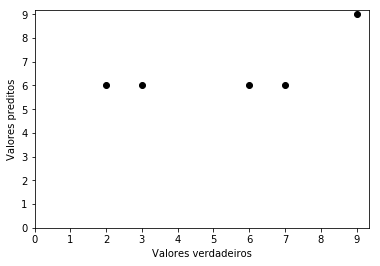

In [49]:
plt.scatter(y_test, y_pred, c = 'black')
plt.xlabel("Valores verdadeiros")
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.ylabel("Valores preditos")
plt.yticks([0,1,2,3,4,5,6,7,8,9])